# What's that Doggy in the Window?
## Data Cleaning and Pre-processing

By: **Bryan Santos**

Have you ever wanted to know the breed of dogs you see in social media or with other people because you like how they look, whether tough or cute?

This project aims to build an application that lets users upload images of a dog and to get its breed. The application will then assess the breed characteristics if it is suitable for the user based on lifestyle. If it is, then the system will redirect the user to dogs of that particular breed that is up for adoption. If not compatible, then the the system will suggest top five most compatible breeds.

The project will utilize multi-class image classification and recommendation systems machine learning models to achieve its goals.

The pet industry is a multi-billion dollar industry even just in the United States alone. The trend of owning pets is on a steady rise. Unfortunately, so do the number of dogs that would be without a permanent home or that would be euthanized. Many people buy dogs because of fad or appearances and abandon them, most likely because they do not realize that dogs of different breeds have unique characteristics and may not necessarily match their lifestyles.

***

This is the third notebook in the project. The purpose of this notebook is to clean and pre-process all the dataset I have gathered through a series of web scraping and API calls.

## 1: Package Imports and Data Load

Below are the packages used to clean the various dataset I have gathered.

In [1]:
import pandas as pd
import numpy as np
import json
import requests
from requests import get
import urllib.request as req
import os, sys, random, string
import tqdm
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import missingno as mno

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

Load the dataframe that recorded all of images gathered from various web scrape sessions and API calls. This dataframe should already have the combined images from www.dog.ceo and Udacity.

In [73]:
### Load dataframe
images_df = pd.read_csv('images_df.csv')

In [74]:
### Delete unnecessaru column
del images_df['Unnamed: 0']
images_df.shape

(28669, 2)

In [75]:
images_df.head(5)

,filename,breed
0,yr5nolw2d8qzb9i3scg4.jpg,setter-irish
1,01g4tqhjevrdzo3pl2ky.jpg,setter-irish
2,lhyq7io1ek6gbwuc2tn8.jpg,setter-irish
3,5971pwrfx0hunc3m4el2.jpg,setter-irish
4,o6vqbkigf4n32xmzrls5.jpg,setter-irish


***

## 2: Images - Data Cleaning

This section aims to clean and preprocess all images gathered from previous steps.

In [76]:
### Get count of unique breeds which will serve as the classes
count_df = images_df.breed.value_counts()

In [77]:
### Convert to dataframe
count_df = pd.DataFrame(count_df)
count_df = count_df.reset_index()
count_df.columns = ['breed', 'count']

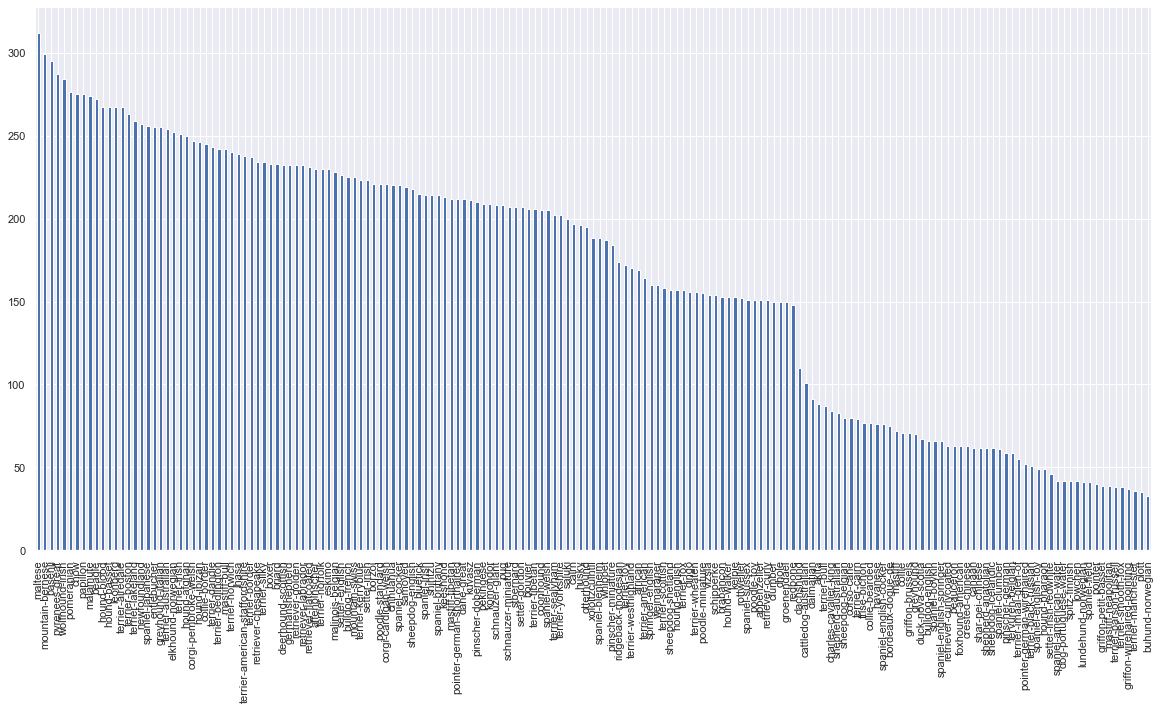

In [29]:
### Quick look at the distribution
images_df["breed"].value_counts().plot.bar(figsize=(20, 10))

The code below is here just in case I need to filter the number of classes I would predict. It is obvious in the visualization that I have a serious **class imbalance** especially when we consider that we have 173 total classes. However,  I want to look at the results of my classification models first before I decide if I will simplify my data my reducing the number of classes, which effectively means reducing the number of images. Transfer Learning may be key in being able to effectively build models on this many classes despite the imbalance. Transfer Learning involves using pre-trained models.

One way to do this is to only include classes that have the count above a certain threshold. The code block below is reserved for this purpose.

In [30]:
### Filter dataset
delete_df = count_df.loc[(count_df['count'] < 50)]

In [31]:
delete_df.shape

(18, 2)

In [32]:
### Validate list
delete_list = delete_df['breed']
delete_list

155            spaniel-english-toy
156                  hound-pharaoh
157          setter-irish-redwhite
158         spaniel-american-water
159           dog-portuguese-water
160                  spitz-finnish
161                        lowchen
162            lundehund-norwegian
163                  spaniel-field
164                        pointer
165           griffon-petit-basset
166             mastiff-neapolitan
167         terrier-parson-russell
168             terrier-smooth-fox
169    griffon-wirehaired-pointing
170             terrier-manchester
171                          plott
172               buhund-norwegian
Name: breed, dtype: object

The code below will be run if it is necessary to delete classes due to lack of images of certain breeds.

In [29]:
### Delete actual folders in the file system

# i = 1

# for folder in delete_list:
    
#     print('[' + str(i) + '] Deleting folder ' + folder)
#     i += 1
    
#     try:
#         shutil.rmtree("images/" + folder + "/")
#     except OSError as e:
#         print ("Error: %s - %s." % (e.filename, e.strerror))

[1] Deleting folder ovcharka-caucasian
[2] Deleting folder mix
[3] Deleting folder dachshund
[4] Deleting folder shiba
[5] Deleting folder cattledog-australian
[6] Deleting folder frise-bichon
[7] Deleting folder akita
[8] Deleting folder pointer-germanlonghair
[9] Deleting folder waterdog-spanish
[10] Deleting folder terrier-patterdale
[11] Deleting folder havanese
[12] Deleting folder mastiff-english
[13] Deleting folder cotondetulear
[14] Deleting folder hound-plott
[15] Deleting folder pitbull
[16] Deleting folder terrier-russell
[17] Deleting folder buhund-norwegian
[18] Deleting folder bulldog-english
[19] Deleting folder australian-shepherd
[20] Deleting folder dalmatian
[21] Deleting folder cockapoo
[22] Deleting folder finnish-lapphund


In [78]:
breed_list = count_df['breed']
breed_list.tail

<bound method NDFrame.tail of 0                          maltese
1                 mountain-bernese
2                          basenji
3                   pyrenees-great
4                  wolfhound-irish
                  ...             
168             terrier-smooth-fox
169    griffon-wirehaired-pointing
170             terrier-manchester
171                          plott
172               buhund-norwegian
Name: breed, Length: 173, dtype: object>

### Choosing Top 50

This section is where I would reduce my dataset to the Top 50 breeds according to the American Kennel Club. This list is based on the number of breed registrations per year so this is a very good indicator of the top breeds that people are interested in. Another reason why I am reducing the dataset is for my project to have more focus - including my models.

In [53]:
print ([name for name in os.listdir("images/") if os.path.isdir(name)])

[]


In [57]:
breedlist = os.listdir("images/")
len(breedlist)

50

***

## 3: Images - Pre-Processing

### Randomizing Filenames

Given that the images were gathered from multiple sources (www.dog.ceo accepts user uploaded images and retained user-specified filenames), some of the filenames include the actual breed of the images. I don't want this to play a factor in the actual classification models which is why I am randomizing the names of each image files.

In [118]:
def do_rename(path):
    '''
    This function checks each file for renaming if they are valid. If
    valid, this runs the create_random_name function to generate the 
    name then does the actual file system renaming.
    
    Parameters:
    - path = image path for renaming
    
    Output:
    - Sets the new randomized filename
    
    '''
    for this in os.listdir(path):
        
        ### Check if valid
        if os.path.isfile(path+this):
            
            ### Get a random name including the previous file extension
            rand = create_random_name(path, os.path.splitext(this)[1])
            
            ### Actual renaming
            os.rename(path+this, path+rand)

        else:
            ### Not a file
            print("\tSkipped:", "'"+this+"'", "Target is not a file")

In [119]:
def create_random_name(path, ext):
    '''
    This function creates a randomized file name and ensures 
    that the generated name has no duplicates.
    
    Parameters:
    - path = image path for renaming
    - ext = file extension
    
    Output:
    - New randomized and unique filename
    
    '''
    check = False
    while check == False:
        rand = "".join(random.sample(string.ascii_lowercase + string.digits, 20)) + ext
        check = True if not os.path.exists(path + rand) else False
    return rand

In [120]:
### Iterate through the images in each folder for renaming
i = 1
for breed in tqdm(breed_list):
    
    ### Print status
    print('[' + str(i) + '] Renaming images in ' + breed)
    i += 1
    
    ### Run renaming functions
    dorename('images/' + breed + '/')

[1] Renaming images in maltese
[2] Renaming images in mountain-bernese
[3] Renaming images in basenji
[4] Renaming images in pyrenees-great
[5] Renaming images in wolfhound-irish
[6] Renaming images in pomeranian
[7] Renaming images in chow
[8] Renaming images in papillon
[9] Renaming images in malamute
[10] Renaming images in beagle
[11] Renaming images in hound-blood
[12] Renaming images in hound-basset
[13] Renaming images in leonberg
[14] Renaming images in terrier-airedale
[15] Renaming images in terrier-boston
[16] Renaming images in terrier-lakeland
[17] Renaming images in newfoundland
[18] Renaming images in spaniel-japanese
[19] Renaming images in entlebucher
[20] Renaming images in greyhound-italian
[21] Renaming images in terrier-australian
[22] Renaming images in elkhound-norwegian
[23] Renaming images in terrier-irish
[24] Renaming images in hound-afghan
[25] Renaming images in corgi-pembroke-welsh
[26] Renaming images in hound-ibizan
[27] Renaming images in collie-border


In [37]:
### Records all new filenames in a new dataframe
labels_df = pd.DataFrame(columns=['filename', 'breed']) 

rootdir = 'images/'

for subdir, dirs, files in tqdm(os.walk(rootdir)):
    for file in files:
        if file == ".DS_Store":
            continue
        else:
            labels_df = labels_df.append({'filename': file,
                                'breed': subdir[7:]}, ignore_index = True) 

In [38]:
labels_df

,filename,breed
0,m3rtu0pyxo1ca2vgf6sq.jpg,setter-irish
1,6gmp18sr3ochjtqef9dn.jpg,setter-irish
2,5hiq1brc93wvls2fag6p.jpg,setter-irish
3,an5jsg6tylr72v0kehmo.jpg,setter-irish
4,rx34ztg01jpwni9hocy2.jpg,setter-irish
...,...,...
28666,vx6bwt49pm7sr2a1koiq.jpg,terrier-norfolk
28667,m12tnyublig08d4af7kw.jpg,terrier-norfolk
28668,0ykgp37b5trh2vwnu9fx.jpg,terrier-norfolk
28669,zo6xdtq5b0r2yn713gia.jpg,terrier-norfolk


In [39]:
### Export dataset
labels_df.to_csv("labels.csv")

### Initial Test, Train Split

Some approaches in image classification require that the images are separated into different training, validation and testing folders. This section does exactly that by randomly transferring the images to corresponding folders. The split ratio is based on the variables set below. I am recording everything to a dataframe again to ensure that I am keeping track of all the movements.

In [66]:
### Split images into various train, test or validation folders

### Prepare dataframe for recording
targets_df = pd.DataFrame(columns=['filename', 'breed', 'folder']) 

### Set variables and create destination folders
root_dir = 'images/'
classes_dir = breed_list
i = 1
train_ratio = 0.80
val_ratio = 0.00
test_ratio = 0.20
os.makedirs(root_dir +'train')
os.makedirs(root_dir +'test')
os.makedirs(root_dir +'validation')

### Create folders
for breed in breed_list:
    os.makedirs(root_dir +'train/' + breed)
    os.makedirs(root_dir +'test/' + breed)
    os.makedirs(root_dir +'validation/' + breed)

### Go through each breed folder
for cls in tqdm(breed_list):

    ### Print status
    print('[' + str(i) + '] Train, val, test split images from ' + cls)
    i += 1

    ### Creating partitions of the data after shuffling
    src = root_dir + cls + '/'

    all_filenames = os.listdir(src)
    np.random.shuffle(all_filenames)
    train_filenames, val_filenames, test_filenames = np.split(np.array(all_filenames),
                                                              [int(len(all_filenames) * train_ratio),int(len(all_filenames) * (train_ratio + val_ratio))])


    train_filenames = [src+'/'+ name for name in train_filenames.tolist()]
    val_filenames = [src+'/' + name for name in val_filenames.tolist()]
    test_filenames = [src+'/' + name for name in test_filenames.tolist()]

    ### Copy-pasting images
    for name in train_filenames:

        shutil.copy(name, root_dir +'train/' + cls )
        split_df = split_df.append({'filename': name,
                                'breed': cls, 'folder': 'train'}, ignore_index = True) 
    for name in val_filenames:

        shutil.copy(name, root_dir +'validation/' + cls)
        split_df = split_df.append({'filename': name,
                                'breed': cls, 'folder': 'validation'}, ignore_index = True) 
    for name in test_filenames:

        shutil.copy(name, root_dir +'test/' + cls)
        split_df = split_df.append({'filename': name,
                                'breed': cls, 'folder': 'test'}, ignore_index = True) 

[1] Train, val, test split images from maltese
[2] Train, val, test split images from mountain-bernese
[3] Train, val, test split images from basenji
[4] Train, val, test split images from pyrenees-great
[5] Train, val, test split images from wolfhound-irish
[6] Train, val, test split images from pomeranian
[7] Train, val, test split images from chow
[8] Train, val, test split images from papillon
[9] Train, val, test split images from malamute
[10] Train, val, test split images from beagle
[11] Train, val, test split images from hound-blood
[12] Train, val, test split images from hound-basset
[13] Train, val, test split images from leonberg
[14] Train, val, test split images from terrier-airedale
[15] Train, val, test split images from terrier-boston
[16] Train, val, test split images from terrier-lakeland
[17] Train, val, test split images from newfoundland
[18] Train, val, test split images from spaniel-japanese
[19] Train, val, test split images from entlebucher
[20] Train, val, te

[153] Train, val, test split images from terrier-imaal-glen-of
[154] Train, val, test split images from pointer-german-wirehaired
[155] Train, val, test split images from terrier-black-russian
[156] Train, val, test split images from spaniel-english-toy
[157] Train, val, test split images from hound-pharaoh
[158] Train, val, test split images from setter-irish-redwhite
[159] Train, val, test split images from spaniel-american-water
[160] Train, val, test split images from dog-portuguese-water
[161] Train, val, test split images from spitz-finnish
[162] Train, val, test split images from lowchen
[163] Train, val, test split images from lundehund-norwegian
[164] Train, val, test split images from spaniel-field
[165] Train, val, test split images from pointer
[166] Train, val, test split images from griffon-petit-basset
[167] Train, val, test split images from mastiff-neapolitan
[168] Train, val, test split images from terrier-parson-russell
[169] Train, val, test split images from terrie

In [67]:
split_df.tail(5)

,filename,breed,folder
28666,images/buhund-norwegian//ts3h9g5qzakx47d0b2mw.jpg,buhund-norwegian,test
28667,images/buhund-norwegian//vgqziy04xlwemtps2af7.jpg,buhund-norwegian,test
28668,images/buhund-norwegian//qp9jcxeuziwfy8371nkd.jpg,buhund-norwegian,test
28669,images/buhund-norwegian//e4fq0t7a92v1uy5rngh3.jpg,buhund-norwegian,test
28670,images/buhund-norwegian//hb9ilckv6wfjr0a35ndu.jpg,buhund-norwegian,test


In [68]:
split_df.to_csv('split_df.csv')

This section also does the transferring of images to specific folders but following a different approach. This time, this transfer all files into just one folder for splitting later in the actual modeling section.

In [60]:
### Transfer all files to one folder but record changes

root_dir = 'images/'
classes_dir = breedlist
i = 1
targets_df = pd.DataFrame(columns=['filename', 'breed']) 

for cls in tqdm(breedlist):

    print('[' + str(i) + '] Copy images from ' + cls)
    i += 1

    ### Creating partitions of the data after shuffling
    src = 'images/' + cls + '/' 

    all_filenames = os.listdir(src)

    ### Copy-pasting images
    for name in all_filenames:

        shutil.copy('images/' + cls + '/' + name, 'images/train/')
        targets_df = targets_df.append({'filename': name,
                                'breed': cls}, ignore_index = True) 

[1] Copy images from dane-great
[2] Copy images from poodle-standard
[3] Copy images from pinscher-doberman
[4] Copy images from rottweiler
[5] Copy images from collie-border
[6] Copy images from terrier-boston
[7] Copy images from pomeranian
[8] Copy images from germanshepherd
[9] Copy images from retriever-golden
[10] Copy images from pointer-german-shorthaired
[11] Copy images from ridgeback-rhodesian
[12] Copy images from dachshund
[13] Copy images from hound-blood
[14] Copy images from bulldog-english
[15] Copy images from terrier-yorkshire
[16] Copy images from shepherd-australian
[17] Copy images from bulldog-french
[18] Copy images from spaniel-english-cocker
[19] Copy images from hound-basset
[20] Copy images from chihuahua
[21] Copy images from spaniel-cocker
[22] Copy images from newfoundland
[23] Copy images from frise-bichon
[24] Copy images from corso-cane
[25] Copy images from pug
[26] Copy images from havanese
[27] Copy images from retriever-chesapeake
[28] Copy images 

In [61]:
### Export to csv
targets_df.to_csv('targets_df.csv')

### Getting File Sizes

This part records file sizes of all images just in case. This may be useful for finetuning our models later or for EDA.

In [127]:
### Prepares dataframe
sizes_df = pd.DataFrame(columns=['path', 
                                'size']) 

### Get file sizes
all_filenames = os.listdir('images/train/')
for path in all_filenames:
    size = os.path.getsize('images/train/' + path)
    sizes_df = sizes_df.append({'path': path, 'size': size}, ignore_index = True)

### Export to csv                               
sizes_df.to_csv('sizes.csv')

***

## 4: Dog Characteristics

This sections contains the process in cleaning the www.dogtime.com dog breed characteristics dataset.

In [49]:
dogs_df = pd.read_csv('dogs_df.csv', index_col=0)

In [50]:
dogs_df.set_index('breed', inplace=True)

In [51]:
dogs_df['dog_breed_group'].value_counts()

Mixed Breed Dogs    120
Working Dogs         45
Companion Dogs       42
Hound Dogs           39
Sporting Dogs        38
Herding Dogs         33
Terrier Dogs         30
Hybrid Dogs          12
Name: dog_breed_group, dtype: int64

In [52]:
dogs_df.shape

(359, 45)

### Removing Mixed Breeds

Dogtime has captured characteristics of 359 dog breeds. However, we only have 173 classes in our dog breed image classifier, which will further be reduced to 50. Because the dog breed recommendations system will be attached to the image classifier, we need to retain only the characteristics of the top 50 dog breeds. In any case, I truly believe that the 50 classes already capture the most popular and common dog breeds so removing more than half of the dogtime dataset is a reasonable move.

In addition, the labels of our classes do not exactly match the labels of our dogtime data. We first need to ensure that they are matched so they can be connected later on.

Upon initial analysis, we can see the dogtime included mixed breed dogs in its dataset. Unfortunately, we do not have images of any mixed breed dogs. Our two sources for the photos were focused on pure breeds. We have no choice but to remove the mixed breeds from our dogtime dataset. Besides, none of the mixed breeds are in the top 50 breeds according to AKC.

In [53]:
dogs_df = dogs_df.loc[dogs_df['dog_breed_group'] != 'Mixed Breed Dogs']

In [54]:
dogs_df['dog_breed_group'].value_counts()

Working Dogs      45
Companion Dogs    42
Hound Dogs        39
Sporting Dogs     38
Herding Dogs      33
Terrier Dogs      30
Hybrid Dogs       12
Name: dog_breed_group, dtype: int64

In [48]:
dogs_df.shape
dogs_df.to_csv('dogtime.csv')

### Missing Values

Now that we have removed the mixed breeds, I need to check if there are missing values that would require further handling such as imputation techniques.

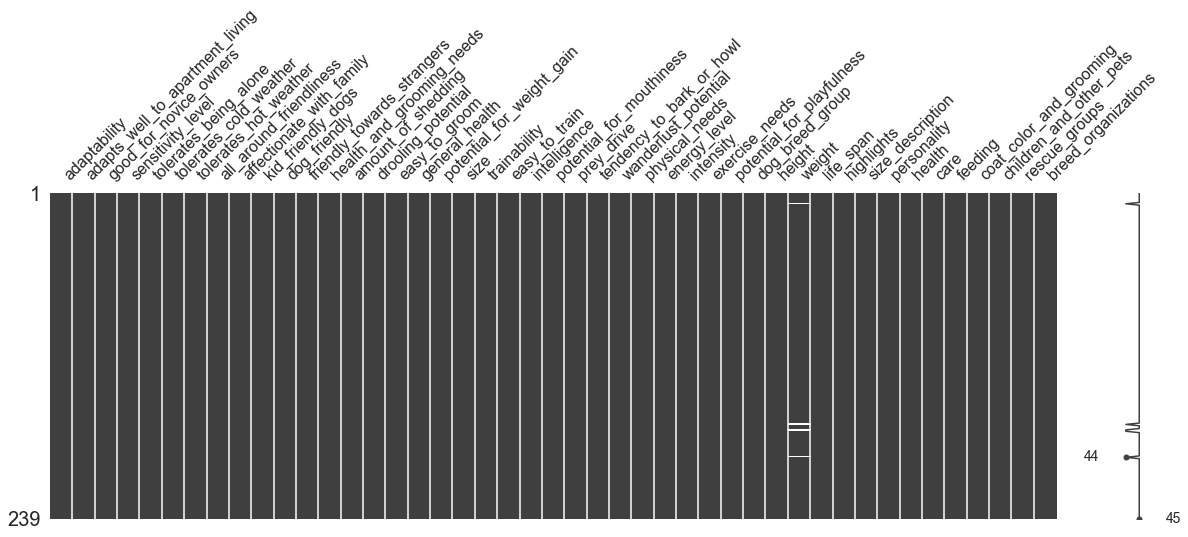

In [13]:
mno.matrix(dogs_df, figsize = (20, 6))
plt.show()

#### Observations:

It seems that there are missing values. However, before we automatically decide to impute anything, it is best to continue the pre-processing and cleaning first to see if the rows with missing values are retained. If they are, then we will need to impute.

### Renaming Labels to Match Images

In [15]:
### Confirming there are 173 labels
labels_df.shape

(173, 2)

In [16]:
labels = labels_df['breed']

In [21]:
#labels = labels.to_list()
labels

['maltese',
 'mountain-bernese',
 'basenji',
 'pyrenees-great',
 'wolfhound-irish',
 'pomeranian',
 'chow',
 'papillon',
 'malamute',
 'beagle',
 'hound-blood',
 'leonberg',
 'hound-basset',
 'terrier-airedale',
 'terrier-boston',
 'terrier-lakeland',
 'newfoundland',
 'spaniel-japanese',
 'entlebucher',
 'greyhound-italian',
 'terrier-australian',
 'elkhound-norwegian',
 'terrier-irish',
 'hound-afghan',
 'corgi-pembroke-welsh',
 'hound-ibizan',
 'collie-border',
 'terrier-dandie',
 'terrier-bedlington',
 'mastiff-bull',
 'terrier-norwich',
 'lhasa',
 'terrier-american-staffordshire',
 'terrier-border',
 'retriever-chesapeake',
 'terrier-silky',
 'boxer',
 'briard',
 'retriever-golden',
 'retriever-labrador',
 'deerhound-scottish',
 'germanshepherd',
 'affenpinscher',
 'retriever-flatcoated',
 'terrier-norfolk',
 'eskimo',
 'malinois-belgian',
 'setter-english',
 'mountain-swiss',
 'bulldog-french',
 'setter-irish',
 'terrier-kerryblue',
 'poodle-standard',
 'corgi-cardigan-welsh',
 '

In [25]:
### Sort alphabetically
labels = sorted(labels)
labels

['affenpinscher',
 'african',
 'akita',
 'appenzeller',
 'basenji',
 'beagle',
 'beauceron',
 'bluetick',
 'bordeaux-dogue-de',
 'borzoi',
 'bouvier',
 'boxer',
 'brabancon',
 'briard',
 'buhund-norwegian',
 'bulldog-english',
 'bulldog-french',
 'cairn',
 'canaan',
 'cattledog-australian',
 'charles-cavalier-king',
 'chihuahua',
 'chow',
 'clumber',
 'collie',
 'collie-bearded',
 'collie-border',
 'coonhound',
 'corgi-cardigan-welsh',
 'corgi-pembroke-welsh',
 'corso-cane',
 'crested-chinese',
 'dachshund',
 'dalmatian',
 'dane-great',
 'deerhound-scottish',
 'dhole',
 'dingo',
 'dog-portuguese-water',
 'duck-nova-scotia',
 'elkhound-norwegian',
 'entlebucher',
 'eskimo',
 'foxhound-american',
 'frise-bichon',
 'germanshepherd',
 'greyhound',
 'greyhound-italian',
 'griffon-brussels',
 'griffon-petit-basset',
 'griffon-wirehaired-pointing',
 'groenendael',
 'havanese',
 'hound-afghan',
 'hound-basset',
 'hound-blood',
 'hound-english',
 'hound-ibizan',
 'hound-pharaoh',
 'hound-walker

In [28]:
dogtime_list = dogs_df['breed']

In [29]:
dogtime_list.to_list()

['afador',
 'affenhuahua',
 'affenpinscher',
 'afghan-hound',
 'airedale-terrier',
 'akbash',
 'akita',
 'akita-chow',
 'akita-pit',
 'akita-shepherd',
 'alaskan-klee-kai',
 'alaskan-malamute',
 'american-bulldog',
 'american-english-coonhound',
 'american-eskimo-dog',
 'american-foxhound',
 'american-hairless-terrier',
 'american-leopard-hound',
 'american-pit-bull-terrier',
 'american-pugabull',
 'american-staffordshire-terrier',
 'american-water-spaniel',
 'anatolian-shepherd-dog',
 'appenzeller-sennenhunde',
 'auggie',
 'aussiedoodle',
 'aussiepom',
 'australian-cattle-dog',
 'australian-kelpie',
 'australian-retriever',
 'australian-shepherd',
 'australian-shepherd-husky',
 'australian-shepherd-lab-mix',
 'australian-shepherd-pit-bull-mix',
 'australian-terrier',
 'azawakh',
 'barbet',
 'basenji',
 'bassador',
 'basset-fauve-de-bretagne',
 'basset-hound',
 'basset-retriever',
 'bavarian-mountain-scent-hound',
 'beabull',
 'beagle',
 'beaglier',
 'bearded-collie',
 'bedlington-terr

In [33]:
dogtime_breeds = []

for dog in dogtime_list:
    if len(dog.split('-')) == 1:
        dogtime_breeds.append(dog)
    elif len(dog.split('-')) == 2:
        dog == dog.split('-')[1] + '-' + dog.split('-')[0]
        dogtime_breeds.append(dog)
    elif len(dog.split('-')) == 3:
        dog == dog.split('-')[2] + '-' + dog.split('-')[0]  + '-' + dog.split('-')[1]
        dogtime_breeds.append(dog)
    elif len(dog.split('-')) == 4:
        dog == dog.split('-')[3] + '-' + dog.split('-')[0]  + '-' + dog.split('-')[1]  + '-' + dog.split('-')[2]
        dogtime_breeds.append(dog)
    elif len(dog.split('-')) == 5:
        dog == dog.split('-')[4] + '-' + dog.split('-')[0]  + '-' + dog.split('-')[1]  + '-' + dog.split('-')[2] + '-' + dog.split('-')[3]
        dogtime_breeds.append(dog)
    else:
        print("There is longer")

In [36]:
dog.split('-')[1]

'terrier'

### Top 50 Breeds

It was finalized that this project will retain only the top 50 breeds according to the American Kennel Club. This is a good source because they measure the actual number of registrations per breed each year, providing us with a reliable indicator of breed popularity. Remember that this project deals with the rise of dogs ownership, so it is better to focus our project on the top breeds.

The top breeds according to AKC are as follows in alphabetical order.

In [3]:
top_breeds = pd.read_csv("unique_breeds.csv", index_col=0)

In [4]:
### List Top 50 breeds
top_breeds['0']

0                          akita
1                         beagle
2                          boxer
3                bulldog-english
4                 bulldog-french
5           cattledog-australian
6                      chihuahua
7                         collie
8                  collie-border
9           corgi-pembroke-welsh
10                    corso-cane
11                     dachshund
12                    dane-great
13                  frise-bichon
14                germanshepherd
15                      havanese
16                  hound-basset
17                   hound-blood
18                         husky
19              malinois-belgian
20                       maltese
21                       mastiff
22                  mastiff-bull
23              mountain-bernese
24                  newfoundland
25                      papillon
26             pinscher-doberman
27    pointer-german-shorthaired
28                    pomeranian
29               poodle-standard
30        

In [91]:
### Ensure count of breeds
len(top_breeds)

50

In [92]:
#top_breeds = top_breeds.values
top_breeds = top_breeds['0']

#top_breeds = [item for sublist in top_breeds for item in sublist]

In [98]:
top_breeds = top_breeds.tolist()

In [61]:
dogs_df = dogs_df.reset_index()
dogs_df.head(4)

,index,breed,adaptability,adapts_well_to_apartment_living,good_for_novice_owners,sensitivity_level,tolerates_being_alone,tolerates_cold_weather,tolerates_hot_weather,all_around_friendliness,...,highlights,size_description,personality,health,care,feeding,coat_color_and_grooming,children_and_other_pets,rescue_groups,breed_organizations
0,0,affenpinscher,3,5,4,3,1,3,3,3,...,"Like many toy dog breeds, the Affenpinscher ca...",Affenpinschers are 9.5 to 11.5 inches tall and...,"The Affen is affectionate and curious, always ...","Affenpinschers are generally healthy, but like...",The Affenpinscher is an ideal dog for apartmen...,Recommended daily amount: 1/4 to 1/2 cup of hi...,Shaggy but neat describes the Affenpinscher's ...,Affenpinschers don't like aggressive behavior ...,Affenpinschers are sometimes bought without an...,"Below are breed clubs, organizations, and asso..."
1,1,afghan-hound,4,5,3,5,2,5,5,4,...,Grooming is essential. Only those who really e...,Males are 27 inches (plus or minus one inch) a...,The Afghan Hound is typically a one-person or ...,"Afghans are generally healthy, but like all br...",Afghan Hounds prefer being inside with family....,Recommended daily amount: 2 to 2.5 cups of hig...,"Properly groomed, the Afghan coat is spectacul...",The Afghan's independent nature and large size...,Afghans are often purchased without any clear ...,"Below are breed clubs, organizations, and asso..."
2,2,airedale-terrier,2,1,2,3,2,3,3,4,...,"Like all Terriers, Airedales have a natural in...","Males stand 23 inches tall, and weigh about 50...","The Airedale is a hard-working, independent, a...","Airedales are generally healthy, but like all ...","The Airedale Terrier is a working dog, and has...",Recommended daily amount: 1.5 to 2.5 cups of h...,The handsome coat of the Airedale Terrier has ...,The fun-loving Airedale makes a good family pe...,Airedales are often purchased without any clea...,"Below are breed clubs, organizations, and asso..."
3,3,akbash,3,1,2,3,4,4,2,4,...,Akbash coats are only white. These dogs were b...,"As the Akbash is a relatively pure breed, ther...",The Akbash is a gentle dog who is very protect...,The Akbash breed is predisposed to some of the...,"As with all dogs, you should keep up with your...",An ideal Akbash diet should be formulated for ...,Akbash coats are only white. These beautiful p...,"Because the Akbash is a large dog, they can ea...","Because the Akbash is a somewhat rare breed, i...",Not available


In [44]:
#dogs_df = dogs_df.loc[(dogs_df.breed in top_breeds)]
dogs_df = dogs_df.loc[dogs_df['breed'].isin(top_breeds)]

***

## 4: Dog for Adoption

This contains the process I used to clean and pre-process the adoption dataset from petfinder.

In [156]:
adoption_df = pd.read_csv("adoption_df.csv", index_col = 0)

In [157]:
adoption_df.head(3)

,label,link
0,"['Cary in NY - So Gentle & Sweet!, adoptable D...",['https://www.petfinder.com/dog/cary-in-ny-so-...
1,"[""Darlin', adoptable Dog, Young Female Pit Bul...",['https://www.petfinder.com/dog/darlin-3366113...
2,"['Thea Queen, adoptable Dog, Adult Female Pit ...",['https://www.petfinder.com/dog/thea-queen-472...


We need to extract key features such as name, age, sex and breed of the dogs from the main label column. The label column was the raw result from the webscraping performed on petfinder. The column is dirty and has unneccessary characters.

In [158]:
### Clean label before feature extraction
adoption_df['label'] = adoption_df['label'].str.replace("[", "")
adoption_df['label'] = adoption_df['label'].str.replace("\'", "")
adoption_df['label'] = adoption_df['label'].str.replace("\"", "")
adoption_df['label'] = adoption_df['label'].str.replace("]", "")

In [159]:
adoption_df['name'] = adoption_df['label'].str.split(',').str[0]
adoption_df['sex_age_breed'] = adoption_df['label'].str.split(',').str[2]

### Gender

In [161]:
### Extract dog gender
adoption_df['sex'] = adoption_df['sex_age_breed'].str.split(' ').str[2]

In [162]:
### Remove dirty columns
adoption_df = adoption_df.loc[(adoption_df['sex'] == 'Male') | (adoption_df['sex'] == 'Female')]

In [163]:
### Validate gender distribution
adoption_df['sex'].value_counts()

Male      33747
Female    29545
Name: sex, dtype: int64

### Age Range

In [164]:
### Extract dog age range
adoption_df['age'] = adoption_df['sex_age_breed'].str.split(' ').str[1]

In [165]:
### Validate age distribution
adoption_df['age'].value_counts()

Adult     35899
Young     15829
Senior     6878
Puppy      4686
Name: age, dtype: int64

### Breed

In [166]:
### Extract dog breed
adoption_df['breed'] = adoption_df['sex_age_breed'].str.split(' ').str[3:]
adoption_df['breed'] = adoption_df['breed'].str.join(',')
adoption_df['breed'] = adoption_df['breed'].str.replace(',',' ')

In [169]:
### Remove dirty columns
adoption_df.drop('label', axis=1, inplace=True)
adoption_df.drop('sex_age_breed', axis=1, inplace=True)

### Adoption Links

In [170]:
### Clean link
adoption_df['link'] = adoption_df['link'].str.replace("[", "")
adoption_df['link'] = adoption_df['link'].str.replace("\'", "")
adoption_df['link'] = adoption_df['link'].str.replace("]", "")
adoption_df

,link,name,sex,age,breed
0,https://www.petfinder.com/dog/cary-in-ny-so-ge...,Cary in NY - So Gentle & Sweet!,Female,Young,Great Pyrenees
1,https://www.petfinder.com/dog/darlin-33661138/...,Darlin,Female,Young,Pit Bull Terrier
2,https://www.petfinder.com/dog/thea-queen-47256...,Thea Queen,Female,Adult,Pit Bull Terrier Mix
3,https://www.petfinder.com/dog/chloe-47211945/n...,Chloe,Female,Senior,Pit Bull Terrier Mix
4,https://www.petfinder.com/dog/sheba-47211940/n...,Sheba,Female,Adult,Pit Bull Terrier Mix
...,...,...,...,...,...
63586,https://www.petfinder.com/dog/pooches-45818126...,Pooches,Female,Adult,Terrier
63587,https://www.petfinder.com/dog/diggity-45818191...,Diggity,Male,Adult,Dachshund Mix
63588,https://www.petfinder.com/dog/amaya-45818077/g...,Amaya,Female,Young,Miniature Pinscher
63589,https://www.petfinder.com/dog/libby-45818067/g...,Libby,Female,Adult,Pit Bull Terrier


### Missing Values

Verify if there are other rows that have missing values for proper handling later on.

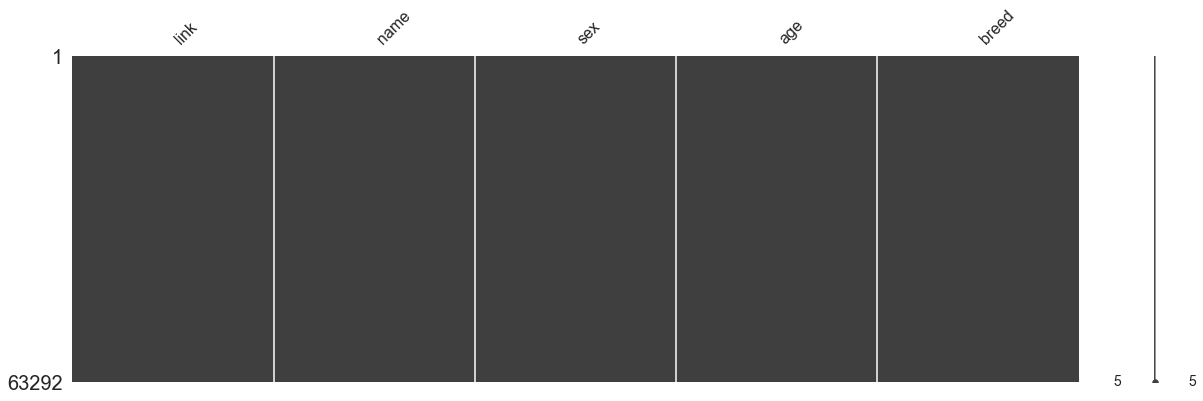

In [172]:
mno.matrix(adoption_df, figsize = (20, 6))
plt.show()

### Breed Matching

After previous cleaning done to the other datasets, we now need to match the breeds listed in the adoption dataset to the others.

In [6]:
adoption_df = pd.read_csv('adoption_dogs.csv', index_col=0)

The cell below were ran manually for each breed to ensure matching names.

In [48]:
adoption_df['breed'] = adoption_df['breed'].str.lower()

### Data Export

In [49]:
adoption_df.to_csv('adoption_dogs.csv')